# Text Analytics Final Project:
# Customer Recommendation System on Yelp London Restaurant
## Group 2: Jinming Li, Mark Babbe, Tammy Huang, Vir Mehta
---

### 1) Develop multithreading web scraper to fetch all user generated contents posted in each restaurant in London
<br>In this section, I developed a web scraper using multithreading technics (which would increase the overal scraping speed drastically) and use the multithreading web scraper to extract all the user generated contents of restaurants in London: https://www.yelp.com/search?find_desc=restaurants&find_loc=London. The steps are as such:</br>

<br>**Step 1: Extract each restaurant url (around 1000 urls);</br>
<br>Step 2: Scrape all user posts from each url, aka restaurant;</br>
<br>Step 3: Implementation in Main and stored the required dataframe (yelp_london_restaurant_comment);**</br>

The *yelp_london_restaurant_comment* dataframe has **55392** rows and **3** columns (Date, Rating, Comment), for example:

Index | Restaurant | Date | Rating | Comment
--- | --- | --- | --- | ---
0 | Franklin Barbecue | 10/08/2018 | 4.5 | Text analytics is my favorite class
1 | Torchy's Taco | 08/01/2017 | 5.0 | Prof. Barua is the best professor I have ever met
2 | Titaya's Thai Cuisine | 05/24/2017 | 5.0 | Greatest food and good service
... | ... | ... | ... | ...

In [1]:
from pandas import Series, DataFrame
from matplotlib import pyplot as plt
from selenium import webdriver
from emoji import emojize
import pandas as pd
import numpy as np
import threading
import queue
import re
import os
%matplotlib inline

# Set up chromedriver.exe
chromedriver = 'C:\Program Files (x86)\Google\Chrome\Application/chromedriver.exe'
os.environ['webdriver.chrome.driver'] = chromedriver
# Control loading pictures and JavaScript and disable infobars
options = webdriver.ChromeOptions()
prefs = {'profile.default_content_setting_values' : {
    'images' : 2,
    'javascript' : 2}} 
options.add_experimental_option('prefs', prefs)
options.add_argument('disable-infobars')

###### Step 1: Extract each restaurant url (around 3500 urls) ######
# Define class Thread_restaurant to scrape each restaurant url 
class Thread_restaurant(threading.Thread):
    def __init__(self, name, queue):
        threading.Thread.__init__(self)
        self.name = name
        self.queue = queue
        
    def run(self):
        while not self.queue.empty():
            scrape_restaurant(self.queue)

# Define scrape_restaurant function
def scrape_restaurant(queue):
    # Get one of url from restaurant_page queue
    url_get = queue.get()
    # Set browser
    browser = webdriver.Chrome(chromedriver, chrome_options = options)
    browser.get(url_get)
    restaurant_list = browser.find_elements_by_css_selector('a.biz-name.js-analytics-click')
    for restaurant in restaurant_list:
        url_link = restaurant.get_attribute('href')
        allurl_list.append(url_link)
    browser.quit()
    
###### Step 2: Scrape all comments from each url ######
# Define class Thread_comment to scrape all comments from each url
class Thread_comment(threading.Thread):
    def __init__(self, name, queue):
        threading.Thread.__init__(self)
        self.name = name
        self.queue = queue
    
    def run(self):
        while not self.queue.empty():
            scrape_comment(self.queue)
        
# Define scrape_comment function
def scrape_comment(queue):
    # Get one of url from restaurant_url queue
    url_get = queue.get()
    # Set browser
    browser = webdriver.Chrome(chromedriver, chrome_options = options)
    browser.get(url_get)
    # Get how many comment pages in one restaurant
    try:
        page_text = browser.find_element_by_css_selector('div.page-of-pages.arrange_unit.arrange_unit--fill').text
        number = int(re.search(r'Page 1 of ([0-9]+)', page_text).group(1))
        # Get all comments from pages with one restaurant
        for i in range(number):
            page_url = url_get + '&start=' + str(i  * 20)
            browser.get(page_url)
            date_rawlist = browser.find_elements_by_css_selector('span.rating-qualifier')
            rating_rawlist = browser.find_elements_by_css_selector('div.i-stars')
            content_rawlist = browser.find_elements_by_tag_name('p')
            previous_rawlist = browser.find_elements_by_css_selector('div.previous-review.clearfix')
            for eachdate in date_rawlist:
                if eachdate.get_attribute('class') == 'rating-qualifier':
                    date = re.search(r'[0-9/]+', eachdate.text).group()
                    dateList.append(date)
            for i, eachrating in enumerate(rating_rawlist):
                find = re.search(r'rating-large', eachrating.get_attribute('class'))
                if find and i != len(rating_rawlist) - 1:
                    rating = re.search(r'(.*) star rating', eachrating.get_attribute('title')).group(1)
                    ratingList.append(rating)
            for eachcontent in content_rawlist:
                if eachcontent.get_attribute('lang') == 'en':
                    contentList.append(eachcontent.text)
            for eachprevious in previous_rawlist:
                try:
                    previous = eachprevious.find_element_by_css_selector('span.js-content-toggleable.hidden').text
                    contentList.append(previous)
                except Exception:
                    previous = re.search(r'([\s0-9/]+Previous review)([\S\s]*)(Was this review …?)', eachprevious.text).group(2)
                    contentList.append(previous)
    except Exception:
        pass
    browser.quit()

###### Step 3: Implementation in Main ######
if __name__ == '__main__':
    ### Step 1: Extract each restaurant url (around 1000 urls) ###
    # Create restaurant_page queue with size of 100
    restaurant_page = queue.Queue(100)
    for i in range(33):
        url_page = 'https://www.yelp.com/search?find_desc=Restaurants&find_loc=London&start=' + str(i * 30)
        restaurant_page.put(url_page)
        
    # Create allurl_list for all the restaurant url
    allurl_list = []
    z
    # Create 5 threads to scrape all the restaurant url
    thread_restaurantlist = ['Thread_Restaurant 1', 'Thread_Restaurant 2', 'Thread_Restaurant 3', 'Thread_Restaurant 4', 'Thread_Restaurant 5']
    thread_list = []
    for thrname in thread_restaurantlist:
        thread_new = Thread_restaurant(thrname, restaurant_page)
        thread_new.start()
        thread_list.append(thread_new)

    for eachthread in thread_list:
        eachthread.join()
    print(emojize("Step 1 finished!:penguin::turtle::ram::whale::panda_face:", use_aliases = True))
    
    ### Step 2: Scrape all comments from each restaurant ###
    # Create restaurant_url queue with size equals to the number of restaurant urls
    restaurant_url = queue.Queue(len(allurl_list))
    for eachurl in allurl_list:
        restaurant_url.put(eachurl)

    # Create contentList, ratingList, dateList for all the comment metadata and text data
    contentList = []
    ratingList = []
    dateList = []
    
    # Create 5 threads Thread_comment to scrape all comment metadata and contents
    thread_commentList = ['Thread_Comment 1', 'Thread_Comment 2', 'Thread_Comment 3', 'Thread_Comment 4', 'Thread_Comment 5']
    thread_list = []
    for thrname in thread_commentList:
        thread_newcomment = Thread_comment(thrname, restaurant_url)
        thread_newcomment.start()
        thread_list.append(thread_newcomment)
    
    for eachthread in thread_list:
        eachthread.join()
    print(emojize("Step 2 finished!:cherry_blossom::tulip::four_leaf_clover::sunflower::hibiscus:", use_aliases = True))
    
    ### Step 3: Converted into DataFrame
    minindex = min(len(dateList), len(ratingList), len(contentList))
    DateList = dateList[:minindex]
    RatingList = ratingList[:minindex]
    ContentList = contentList[:minindex]
    yelp_london_restaurant_comment = DataFrame({'Date' : DateList, 'Rating' : RatingList, 'Comment' : ContentList})
    print(emojize("All finished! Let's go celebrate! :palm_tree::sunny::ocean::wine_glass::beers:", use_aliases = True))
# print(emojize("Step 1 finished!:penguin::turtle::ram::whale::panda_face:", use_aliases = True))
# print(emojize("Step 2 finished!:cherry_blossom::tulip::four_leaf_clover::sunflower::hibiscus:", use_aliases = True))
# print(emojize("All finished! Let's go celebrate! :palm_tree::sunny::ocean::wine_glass::beers:", use_aliases = True))

Step 1 finished!🐧🐢🐏🐳🐼
Step 2 finished!🌸🌷🍀🌻🌺
All finished! Let's go celebrate! 🌴☀🌊🍷🍻


In [2]:
yelp_london_restaurant_comment = pd.read_csv('C:/Users/Kimmy/Desktop/Final Project/Yelp_London_Restaurant.csv', index_col = 0)
restaurant_name = pd.read_csv('C:/Users/Kimmy/Desktop/Final Project/Restaurant.csv', index_col = 0)
yelp_london_restaurant_comment =  pd.concat([yelp_london_restaurant_comment, restaurant_name], axis = 1)
yelp_london_restaurant_comment = yelp_london_restaurant_comment.reindex(columns = ['Restaurant', 'Date', 'Rating', 'Comment'])
yelp_london_restaurant_comment.shape

(50879, 4)

In [3]:
yelp_london_restaurant_comment.head(5)

,Restaurant,Date,Rating,Comment
0,Ffiona’s Restaurant,8/16/2018,5.0,great food in unexpected setting server was kn...
1,Ffiona’s Restaurant,4/8/2018,3.0,i was really looking forward to trying this di...
2,Ffiona’s Restaurant,8/21/2018,2.0,cute restaurant and nice location the gist pre...
3,Ffiona’s Restaurant,9/3/2018,5.0,i was going to be in london for four days spen...
4,Ffiona’s Restaurant,6/14/2017,4.0,yes yes and yes wonderful place for fish and i...


### 2) Data Preprocessing to the Yelp London Restaurant Comment data
#### 2.1) Conduct data cleaning where **1)** remove empty content; **2)** remove '\r', '\n', and punctuation; **3)** remove redundant spaces; **4)** convert all words into lower case

In [4]:
from string import punctuation

def clean(x):
    x = x.replace('\r', ' ')
    x = x.replace('\n', ' ')
    for eachpunc in punctuation:
        x = x.replace(eachpunc, ' ')
    x = re.sub(r'[£0-9]+', ' ', x)
    x = re.sub(r'[\s]+', ' ', x)
    return x.strip().lower()
    
yelp_london =  yelp_london_restaurant_comment[yelp_london_restaurant_comment['Comment'] != '']
yelp_london = pd.concat([yelp_london[['Restaurant', 'Date', 'Rating']], yelp_london['Comment'].map(clean)], axis = 1)
yelp_london.index = np.arange(len(yelp_london))
yelp_london['Date'] = pd.to_datetime(yelp_london['Date'])
yelp_london.head()

,Restaurant,Date,Rating,Comment
0,Ffiona’s Restaurant,2018-08-16,5.0,great food in unexpected setting server was kn...
1,Ffiona’s Restaurant,2018-04-08,3.0,i was really looking forward to trying this di...
2,Ffiona’s Restaurant,2018-08-21,2.0,cute restaurant and nice location the gist pre...
3,Ffiona’s Restaurant,2018-09-03,5.0,i was going to be in london for four days spen...
4,Ffiona’s Restaurant,2017-06-14,4.0,yes yes and yes wonderful place for fish and i...


#### 2.2) Exploratory data analysis where **1)** plot the potential relationships (time of year & ratings); **2)** examine Zipf's Law on word frequency 

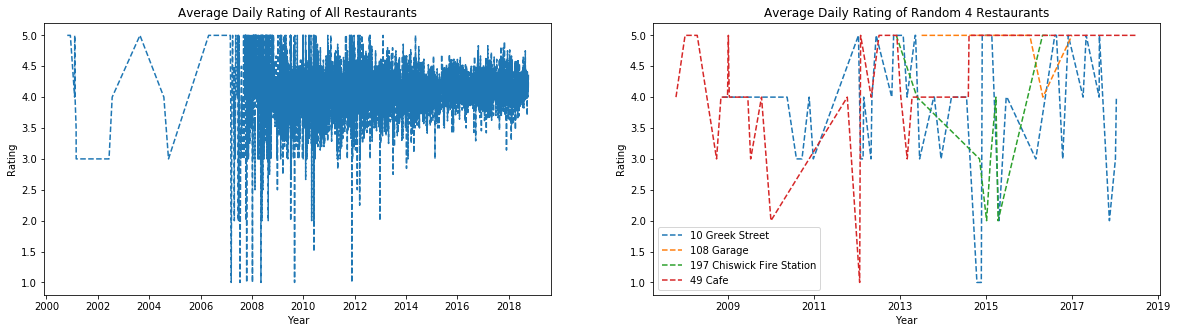

In [5]:
fig, axes = plt.subplots(1, 2, figsize = (20, 5))
allres_daily_mean_rating = yelp_london.groupby('Date')['Rating'].mean().reset_index()
allres_daily_mean_rating = allres_daily_mean_rating.sort_values(by = 'Date')
axes[0].plot(allres_daily_mean_rating['Date'], allres_daily_mean_rating['Rating'], linestyle = '--')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Rating')
axes[0].set_title('Average Daily Rating of All Restaurants')

def restaurant_plot(df, name):
    df = df.groupby(['Restaurant', 'Date'])['Rating'].mean().reset_index()
    df = df.sort_values(by = 'Date')
    axes[1].plot(df['Date'], df['Rating'], linestyle = '--', label = name)


for cursor, (name, chunk) in enumerate(yelp_london.groupby('Restaurant')):
    if int(cursor) < 4:
        restaurant_plot(chunk, name)
        cursor += 1
    else:
        break
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Rating')
axes[1].set_title('Average Daily Rating of Random 4 Restaurants')
axes[1].legend(loc = 'best')

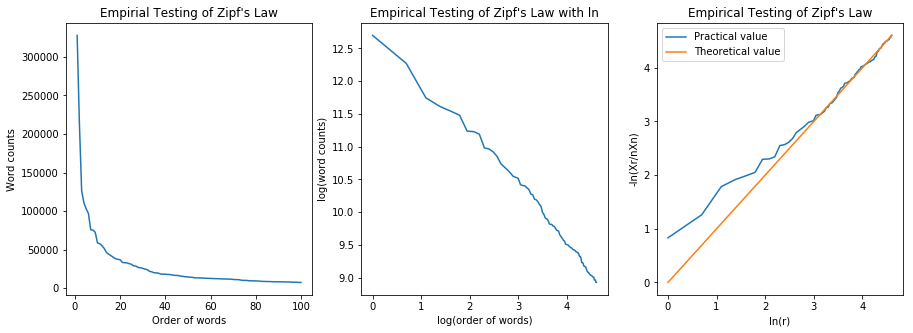

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from math import log

wordcounter_zipf = CountVectorizer()
dtm_zipf = wordcounter_zipf.fit_transform(yelp_london['Comment']).todense()
wordcount_zipf = DataFrame(dtm_zipf, columns = wordcounter_zipf.get_feature_names()).sum(axis = 0)
word_top100_zipf = wordcount_zipf.sort_values(ascending = False)[:100]
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(range(1, 101), word_top100_zipf.values)
ax[0].set_xlabel('Order of words')
ax[0].set_ylabel('Word counts')
ax[0].set_title("Empirial Testing of Zipf's Law")

ax[1].plot(Series(range(1, 101)).map(log), word_top100_zipf.map(log))
ax[1].set_xlabel('log(order of words)')
ax[1].set_ylabel('log(word counts)')
ax[1].set_title("Empirical Testing of Zipf's Law with ln")

ax[2].plot(Series(range(1, 101)).map(log), -(word_top100_zipf / (100 * word_top100_zipf.iloc[-1])).map(log), label = 'Practical value')
ax[2].plot(Series(range(1, 101)).map(log), Series(range(1, 101)).map(log), label = 'Theoretical value')
ax[2].set_xlabel('ln(r)')
ax[2].set_ylabel('-ln(Xr/nXn)')
ax[2].set_title("Empirical Testing of Zipf's Law")
ax[2].legend(loc = 'best')

### 3) Topic Modeling with Latent Dirichlet Allocation (LDA)

#### Using Latent Dirichlet Allocation (LDA) to generate 10 topics (by default) and label these 10 topics

In [5]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

wordcounter = CountVectorizer(max_df = 0.95, min_df = 10, stop_words = 'english')
document_dtm = wordcounter.fit_transform(yelp_london['Comment']).todense()
lda = LatentDirichletAllocation(random_state = 300)
document_topic = lda.fit_transform(document_dtm)

def print_topic_word(x):
    topic = x.name
    top10_word = ' '.join(x.sort_values(ascending = False)[:10].index.tolist())
    print(topic + ': ' + top10_word)
    return

word_topic_df = DataFrame(lda.components_.T, index = wordcounter.get_feature_names(), columns = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10'])
result = word_topic_df.apply(print_topic_word)

Topic 1: food great place london service good best amazing restaurant delicious
Topic 2: steak menu restaurant meal wine dessert dish course just cooked
Topic 3: breakfast tea eggs brunch coffee place good afternoon like toast
Topic 4: place good food great pub bar beer like nice really
Topic 5: fish chips burger good fries sauce london just place like
Topic 6: like food just pizza good place don really ve italian
Topic 7: food service table good place time restaurant just order came
Topic 8: chicken indian good lamb curry food ramen spicy naan rice
Topic 9: sushi noodles japanese good place food soup mash pie chinese
Topic 10: good food really great delicious nice chicken salad place service


In [6]:
document_topic = DataFrame(document_topic, columns = ['Service', 'Steak', 'Breakfast', 'Bar', 'Fish&Chips', 'Italian', 'Order', 'Indian', 'Japanese', 'Salad'])
document_topic_df = DataFrame(pd.concat([yelp_london[['Restaurant', 'Date', 'Rating']], document_topic], axis = 1), 
                              columns = ['Date', 'Rating'] + document_topic.columns.values.tolist())
document_topic_df.head()

,Date,Rating,Service,Steak,Breakfast,Bar,Fish&Chips,Italian,Order,Indian,Japanese,Salad
0,2018-08-16,5.0,0.693750,0.252906,0.006668,0.006668,0.006668,0.006668,0.006669,0.006668,0.006667,0.006669
1,2018-04-08,3.0,0.003227,0.356645,0.003227,0.003227,0.230936,0.003226,0.003226,0.092579,0.003227,0.300480
2,2018-08-21,2.0,0.002632,0.002633,0.002632,0.002632,0.002632,0.451977,0.002632,0.002632,0.002632,0.526966
3,2018-09-03,5.0,0.458210,0.242819,0.001235,0.001235,0.029119,0.001235,0.178673,0.085004,0.001235,0.001235
4,2017-06-14,4.0,0.138105,0.157693,0.002632,0.346390,0.045694,0.298957,0.002632,0.002632,0.002632,0.002632


### 4) Using Predictive Models to Predict Rating based on Topics

Using Multiple Linear Regression, Random Forest, Gradient Boosting to predict rating with the chosen 10 topic being the input variables

D:\Anaconda3.0\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3.0\lib\site-packages\ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
D:\Anaconda3.0\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Training RMSE,Testing RMSE
MLR,1.00467,1.01009
RF,0.45839,1.09524
GBT,1.00043,1.01077


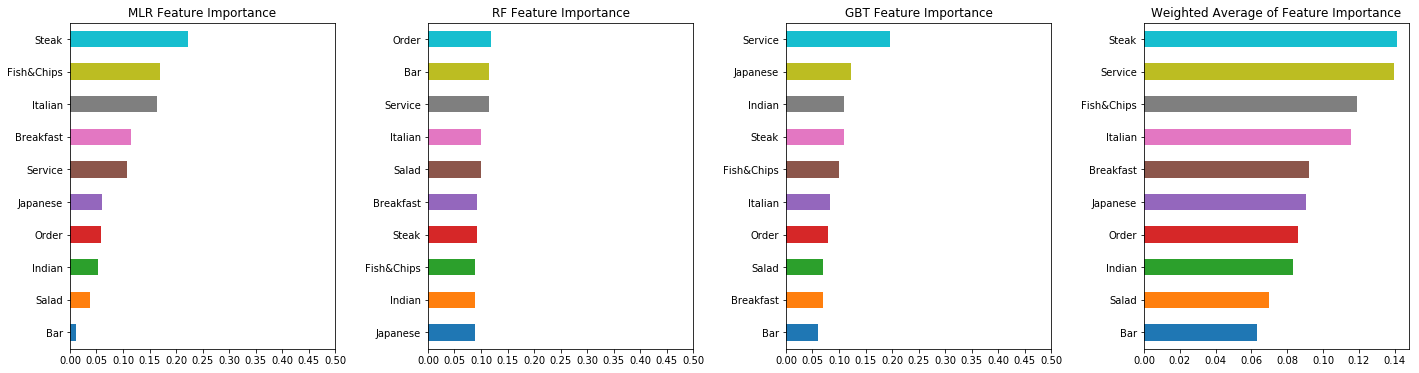

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from math import sqrt

X_train, X_test, Y_train, Y_test = train_test_split(document_topic_df[['Service', 'Steak', 'Breakfast', 'Bar', 'Fish&Chips', 'Italian', 'Order', 'Indian', 'Japanese', 'Salad']], 
                                                    document_topic_df[['Rating']], test_size = 0.3, random_state = 99)
MLR_model = LinearRegression()
RF_model = RandomForestRegressor(random_state = 99)
GBT_model = GradientBoostingRegressor(max_depth = 2, learning_rate = 0.1, random_state = 99)
fig, axes = plt.subplots(1, 4, figsize = (24, 6))
fig.subplots_adjust(wspace = 0.35)

# Multiple Linear Regression
MLR_model.fit(X_train, Y_train)
ypredict_train_MLR = MLR_model.predict(X_train)
ypredict_test_MLR = MLR_model.predict(X_test)
rmse_train_MLR = round(sqrt(mean_squared_error(Y_train, ypredict_train_MLR)), 5)
rmse_test_MLR = round(sqrt(mean_squared_error(Y_test, ypredict_test_MLR)), 5)
coef_df = DataFrame(MLR_model.coef_.reshape(-1, 1), index = document_topic_df.columns.values[2:], columns = ['Weights'])
(abs(coef_df['Weights']) / abs(coef_df['Weights']).sum()).sort_values().plot(ax = axes[0], kind = 'barh')
axes[0].set_xticks([0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
axes[0].set_title('MLR Feature Importance')

# Random Forest Regressor
RF_model.fit(X_train, Y_train)
ypredict_train_RF = RF_model.predict(X_train)
ypredict_test_RF = RF_model.predict(X_test)
rmse_train_RF = round(sqrt(mean_squared_error(Y_train, ypredict_train_RF)), 5)
rmse_test_RF = round(sqrt(mean_squared_error(Y_test, ypredict_test_RF)), 5)
DataFrame(RF_model.feature_importances_.reshape(-1, 1), index = document_topic_df.columns.values[2:], columns = ['Weights'])['Weights'].sort_values().plot(ax = axes[1], kind = 'barh')
axes[1].set_xticks([0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
axes[1].set_title('RF Feature Importance')

# Gradient Boosting Regressor
GBT_model.fit(X_train, Y_train)
ypredict_train_GBT = GBT_model.predict(X_train)
ypredict_test_GBT = GBT_model.predict(X_test)
rmse_train_GBT = round(sqrt(mean_squared_error(Y_train, ypredict_train_GBT)), 5)
rmse_test_GBT = round(sqrt(mean_squared_error(Y_test, ypredict_test_GBT)), 5)
DataFrame(GBT_model.feature_importances_.reshape(-1, 1), index = document_topic_df.columns.values[2:], columns = ['Weights'])['Weights'].sort_values().plot(ax = axes[2], kind = 'barh')
axes[2].set_xticks([0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
axes[2].set_title('GBT Feature Importance')

# Feature Importance DataFrame for MLR, RF and GBT model
model_feature_importance = pd.concat([DataFrame(abs(coef_df['Weights']) / abs(coef_df['Weights']).sum()), 
 DataFrame(RF_model.feature_importances_.reshape(-1, 1), index = document_topic_df.columns.values[2:], columns = ['Weights']),
 DataFrame(GBT_model.feature_importances_.reshape(-1, 1), index = document_topic_df.columns.values[2:], columns = ['Weights'])], axis = 1)
model_feature_importance.columns = ['MLR Feature Importance', 'RF Feature Importance', 'GBT Feature Importance']

# Weighted Average of Feature Importance
weighted_average_feature_importance = (1/3 * model_feature_importance['MLR Feature Importance'] +  1/3 * model_feature_importance['RF Feature Importance'] + 1/3 * model_feature_importance['GBT Feature Importance']).sort_values().plot(kind = 'barh', ax = axes[3])
axes[3].set_title('Weighted Average of Feature Importance')

# Training RMSE and Testing RMSE for MLR, RF and GBT model
comparison_df = DataFrame([[rmse_train_MLR, rmse_test_MLR], [rmse_train_RF, rmse_test_RF], [rmse_train_GBT, rmse_test_GBT]], index = ['MLR', 'RF', 'GBT'], columns = ['Training RMSE', 'Testing RMSE'])
comparison_df

### 5) Sentiment Analysis on Topics

Customers' general sentiments towards 10 Topics (sentiments range from -1 to 1 which -1 indicates the worst negative sentiment and 1 indicates the best positive sentiment while 0 refers to neutral sentiment.

Index | Service | Steak | Breakfast | Bar | Fish&Chips | Italian | Order | Indian | Japanese | Salad
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- 
Sentiment | 0.171002 | 0.048772 | 0.073888 | 0.063824 | 0.061322 | 0.023536 | 0.191761 | 0.033713 | 0.018528 | 0.023666

Among the 10 topics, in general, **Order** and **Services** are the top 2 topics with the highest positive sentiment.

Among the rest topics which are related to food, in general, **Breakfast, Steak, Bar, Fish&Chips, Indian** food are the top 5 topics while **Salad, Italian, Japanese** food have the lowest positive sentiment.

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

service = ['service', 'services', 'waiter', 'waiters', 'waitress', 'waitresses']
steak = ['steak', 'steaks', 'wine']
breakfast = ['breakfast', 'tea', 'coffee', 'milk', 'egg', 'eggs', 'brunch', 'toast']
bar = ['bar', 'pub', 'beer']
fish_chips = ['fish chips', 'fish chip', 'burger', 'burgers', 'fries', 'sauce']
italian = ['pizza', 'italian', 'italy']
order = ['order', 'place', 'time']
indian = ['indian', 'india', 'curry']
japanese = ['japanese', 'sushi', 'ramen']
salad = ['salad', 'vegetable', 'vegetables']

def parser_sentiment(x, mylist, n):
    sia = SentimentIntensityAnalyzer()
    xlist = x.split(' ')
    sentiment_dict = {}
    for eachword in mylist:
        try:
            wordindex = xlist.index(eachword)
            if wordindex < n and len(xlist) - wordindex >= n + 1:
                xlist_new = xlist[: wordindex + n + 1]
            elif wordindex < n and len(xlist) - wordindex < n + 1:
                xlist_new = xlist
            elif wordindex >= n and len(xlist) - wordindex < n + 1:
                xlist_new = xlist[wordindex - n :]
            else:
                xlist_new = xlist[wordindex - n : wordindex + n + 1]
        except ValueError:
            xlist_new = []
        sentiment_dict[eachword] = sia.polarity_scores(' '.join(xlist_new))['compound']
    return sentiment_dict

def all_sentiment(x):
    total = 0
    for key, value in x.items():
        total += value
    return total

service_sentiment = yelp_london['Comment'].apply(parser_sentiment, args = (service, 6))
steak_sentiment = yelp_london['Comment'].apply(parser_sentiment, args = (steak, 6))
breakfast_sentiment = yelp_london['Comment'].apply(parser_sentiment, args = (breakfast, 6))
bar_sentiment = yelp_london['Comment'].apply(parser_sentiment, args = (bar, 6))
fish_chips_sentiment = yelp_london['Comment'].apply(parser_sentiment, args = (fish_chips, 6))
italian_sentiment = yelp_london['Comment'].apply(parser_sentiment, args = (italian, 6))
order_sentiment = yelp_london['Comment'].apply(parser_sentiment, args = (order, 6))
indian_sentiment = yelp_london['Comment'].apply(parser_sentiment, args = (indian, 6))
japanese_sentiment = yelp_london['Comment'].apply(parser_sentiment, args = (japanese, 6))
salad_sentiment = yelp_london['Comment'].apply(parser_sentiment, args = (salad, 6))

average_service_sentiment = service_sentiment.map(all_sentiment).sum() / len(yelp_london.index)
average_steak_sentiment = steak_sentiment.map(all_sentiment).sum() / len(yelp_london.index)
average_breakfast_sentiment = breakfast_sentiment.map(all_sentiment).sum() / len(yelp_london.index)
average_bar_sentiment = bar_sentiment.map(all_sentiment).sum() / len(yelp_london.index)
average_fishchips_sentiment = fish_chips_sentiment.map(all_sentiment).sum() / len(yelp_london.index)
average_italian_sentiment = italian_sentiment.map(all_sentiment).sum() / len(yelp_london.index)
average_order_sentiment = order_sentiment.map(all_sentiment).sum() / len(yelp_london.index)
average_indian_sentiment = indian_sentiment.map(all_sentiment).sum() / len(yelp_london.index)
average_japanese_sentiment = japanese_sentiment.map(all_sentiment).sum() / len(yelp_london.index)
average_salad_sentiment = salad_sentiment.map(all_sentiment).sum() / len(yelp_london.index)
    
sentiment_topic_df = DataFrame([[average_service_sentiment, average_steak_sentiment, average_breakfast_sentiment, average_bar_sentiment, average_fishchips_sentiment, 
                                average_italian_sentiment, average_order_sentiment, average_indian_sentiment, average_japanese_sentiment, average_salad_sentiment]], index = ['Sentiment'], 
                               columns = ['Service', 'Steak', 'Breakfast', 'Bar', 'Fish&Chips', 'Italian', 'Order', 'Indian', 'Japanese', 'Salad'])
sentiment_topic_df

,Service,Steak,Breakfast,Bar,Fish&Chips,Italian,Order,Indian,Japanese,Salad
Sentiment,0.171002,0.048772,0.073888,0.063824,0.061322,0.023536,0.191761,0.033713,0.018528,0.023666


### 6) Association Between Topics

Replace words with related topics. Two topics among these 10 topics **ARE NOT** correlated according to our lift calculation. It makes sense since one document will not mention multiple topics at the same time.

In [11]:
def topic_replace(x):
    for eachservice in service:
        if eachservice in x.split(' '):
            x = x.replace(eachservice, 'service')
    for eachsteak in steak:
        if eachsteak in x.split(' '):
            x = x.replace(eachsteak, 'steak')
    for eachbreakfast in breakfast:
        if eachbreakfast in x.split(' '):
            x = x.replace(eachbreakfast, 'breakfast')
    for eachbar in bar:
        if eachbar in x.split(' '):
            x = x.replace(eachbar, 'bar')
    for eachfish_chips in fish_chips:
        if eachfish_chips in x.split(' '):
            x = x.replace(eachfish_chips, 'fishchips')
    for eachitalian in italian:
        if eachitalian in x.split(' '):
            x = x.replace(eachitalian, 'italian')
    for eachorder in order:
        if eachorder in x.split(' '):
            x = x.replace(eachorder, 'order')
    for eachindian in indian:
        if eachindian in x.split(' '):
            x = x.replace(eachindian, 'indian')
    for eachjapanese in japanese:
        if eachjapanese in x.split(' '):
            x = x.replace(eachjapanese, 'japanese')
    for eachsalad in salad:
        if eachsalad in x.split(' '):
            x = x.replace(eachsalad, 'salad')
    return x

yelp_london_comment_topic = yelp_london['Comment'].map(topic_replace)

In [12]:
wordcounter_topic = CountVectorizer(max_df = 0.95, min_df = 10, stop_words = 'english')
dtm_comment_topic = wordcounter_topic.fit_transform(yelp_london_comment_topic).todense()
dtm_comment_topic_df = DataFrame(dtm_comment_topic, columns = wordcounter_topic.get_feature_names())
topic_list = ['service', 'steak', 'breakfast', 'bar', 'fishchips', 'italian', 'order', 'indian', 'japanese', 'salad']

lift_topic_df = DataFrame(np.zeros((10, 10)), columns = topic_list, index = topic_list)
for i, eachA in enumerate(lift_topic_df):
    sumA = dtm_comment_topic_df[eachA].sum()
    for j, eachB in enumerate(lift_topic_df):
        sumB = dtm_comment_topic_df[eachB].sum()
        newss = dtm_comment_topic_df[eachA] + dtm_comment_topic_df[eachB]
        sumAB = (newss == 2).sum()
        lift = (sumAB * len(dtm_comment_topic_df)) / (sumA * sumB)
        lift_topic_df.iloc[i, j] = lift
        lift_topic_df.iloc[i, i] = np.nan
lift_topic_df

,service,steak,breakfast,bar,fishchips,italian,order,indian,japanese,salad
service,NaN,0.865632,0.523484,0.680557,0.664554,1.325287,0.401724,1.127435,1.168757,1.451506
steak,0.865632,NaN,0.798116,0.996270,0.913867,1.562073,0.802629,1.426521,1.370101,1.673449
breakfast,0.523484,0.798116,NaN,0.673838,0.668743,1.223918,0.445671,1.054513,1.053200,1.276570
bar,0.680557,0.996270,0.673838,NaN,0.796342,1.544956,0.535264,1.314979,1.343322,1.622236
fishchips,0.664554,0.913867,0.668743,0.796342,NaN,1.384463,0.567358,1.231855,1.247346,1.481215
italian,1.325287,1.562073,1.223918,1.544956,1.384463,NaN,1.400251,2.025389,1.820716,2.167893
order,0.401724,0.802629,0.445671,0.535264,0.567358,1.400251,NaN,1.075007,1.270669,1.445529
indian,1.127435,1.426521,1.054513,1.314979,1.231855,2.025389,1.075007,NaN,1.743485,2.100101
japanese,1.168757,1.370101,1.053200,1.343322,1.247346,1.820716,1.270669,1.743485,NaN,1.883854
salad,1.451506,1.673449,1.276570,1.622236,1.481215,2.167893,1.445529,2.100101,1.883854,NaN


### 7) Recommendation System Using Cosine Similarity Between Documents

Name your criteria and we use the cosine similarity to find which one of the documents is the most similar so as to recommend the restaurant.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def recommendation_restaurant():
    requirement = clean(input('Please specify your requirement:'))
    sample_size = int(input('Please choose the sample size to compare:'))
    yelp_london_sample = yelp_london.sample(n = sample_size, random_state = 42)[['Comment']]
    require_yelp_df = pd.concat([DataFrame([requirement], columns = ['Comment']), yelp_london_sample], axis = 0)
    tfidf_counter = TfidfVectorizer(max_df = 0.95, min_df = 10, stop_words = 'english', smooth_idf = True)
    tfidf_document = tfidf_counter.fit_transform(require_yelp_df['Comment']).todense()
    tfidf_document_df = DataFrame(tfidf_document, columns = tfidf_counter.get_feature_names(), index = require_yelp_df.index.values)
    requirement_similarity = DataFrame(cosine_similarity(tfidf_document_df), columns = tfidf_document_df.index.values).iloc[0, ]
    requirement_similarity.iloc[0] = np.nan
    similar_restaurant_index = requirement_similarity.idxmax()
    similar_top10 = DataFrame(requirement_similarity.sort_values(ascending = False).head(10)).reset_index()
    similar_top10.columns = ['Restaurant Index', 'Similarity']
    similar_top10['Restaurant Index'] = similar_top10['Restaurant Index'].map(lambda x: yelp_london['Restaurant'].iloc[x])
    similar_top10.index = requirement_similarity.sort_values(ascending = False).head(10).index
    similar_top10.columns = ['Restaurant', 'Similarity']
    print('The Restaurant you should go:', yelp_london['Restaurant'].iloc[similar_restaurant_index])
    return similar_top10

recommendation_restaurant()

Please specify your requirement: I like Japanese food
Please choose the sample size to compare: 20000


The Restaurant you should go: Ottolenghi


,Restaurant,Similarity
22004,Ottolenghi,0.658293
22096,The English Rose Cafe and Tea Shop,0.583705
29035,Pizzeria Pappagone,0.582442
22049,The English Rose Cafe and Tea Shop,0.503406
21973,Nanban,0.495633
29019,Pizzeria Pappagone,0.480998
37072,The Ladbroke Arms,0.473628
4346,BunBunBun Vietnamese Food,0.460076
4640,On The Bab,0.452707
45559,Mimos Cafe,0.434933
